### Dream3

In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from src.models import NAVAR_UA, TAMCaD_UA
from src.data import load_dataset
from src.training import train_model, train_test_split
from src.eval import plot_contemporaneous_relationships, plot_all_contemporaneous_relationships, plot_heatmaps, plot_heatmaps_grid
from src.utils import min_max_normalization
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display
from lingam.utils import make_dot

In [2]:
dataset = load_dataset('causeme', 'river-runoff_N-12_T-4600')[0]

print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

model_variations = {
    'TAMCaD': {'model_type': TAMCaD_UA, 'lambda1': 0.01, 'gamma': 0.0, 'use_gumbel': True, 'n_blocks': 2, 'n_layers': 2, 'kernel_size': 2, 'lr': 5e-4, 'dropout': 0.1, 'weight_sharing':True, 'hidden_dim': 16},
    'NAVAR': {'model_type': NAVAR_UA, 'lambda1': 0.3, 'beta': 0.5, 'n_blocks': 1, 'n_layers': 2, 'kernel_size': 3, 'lr': 5e-4, 'dropout': 0.2, 'hidden_dim': 32, },
}
params = {
    'experiment_name': 'river-runoff-uncertainty',
    'weight_decay': 1e-8,
    'test_size': 0.0,
    'epochs': 300,
    'n_ensembles': 30
}

{'name': 'river-runoff_N-12_T-4600', 'data': torch.Size([1, 12, 4600])}


In [3]:
all_results = {}

for id, model_params in model_variations.items():
    print('Process', id)
    all_results[id] = []
    for _ in range(1):
        all_results[id].append(train_model(
            experiment_run=id,
            dataset=dataset,
            **model_params,
            **params
        ))

Process TAMCaD


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\mauri\.conda\envs\causal-discovery\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[train] loss=0.38: 100%|█████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.11it/s]


Process NAVAR


[train] loss=0.01: 100%|█████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.18it/s]


In [4]:
# Initialize the arrays to store the data
M = len(all_results)  # Number of models
N = len(next(iter(all_results.values())))  # Assuming all models have the same number of runs
T = len(next(iter(next(iter(all_results.values()))))['train_metrics']['loss'][1])  # Number of timesteps

losses = np.zeros((M, N, T))
training_times = np.zeros((M, N, T))
aurocs = np.zeros((M, N, T))
best_aurocs = np.zeros((M, N))
combined_matrix = []

# Iterate through each model's results
model_names = []
for i, (model_name, results_list) in enumerate(all_results.items()):
    model_names.append(model_name)
    for j, result in enumerate(results_list):
        losses[i, j, :] = result['train_metrics']['loss'][1].numpy()
        training_times[i, j, :] = np.full(T, 1000 * result['model_params']['training_time_per_epoch'])

# Compute averages and standard deviations
avg_losses = np.mean(losses, axis=1)
avg_training_times = np.mean(training_times, axis=1)
avg_aurocs = np.mean(aurocs, axis=1)
avg_best_aurocs = np.mean(best_aurocs, axis=1)


std_losses = np.std(losses, axis=1)
std_aurocs = np.std(aurocs, axis=1)

# Create the table
table_data = {
    "Model": model_names,
    "Loss (avg)": np.mean(avg_losses, axis=1),
    "Time per Epoch (ms) (avg)": np.mean(avg_training_times, axis=1)
}
results_df = pd.DataFrame(table_data)
results_df.set_index("Model", inplace=True)
results_df

dict_keys(['prediction', 'attention_logits', 'attention_logits_ep', 'attention_logits_al', 'matrix', 'matrix_ep', 'matrix_al', 'matrix_temporal'])
dict_keys(['prediction', 'contributions', 'contributions_ep', 'contributions_al', 'matrix', 'matrix_ep', 'matrix_al', 'matrix_temporal'])


,Loss (avg),Time per Epoch (ms) (avg)
Model,,
TAMCaD,0.604576,164.881168
NAVAR,1.250042,109.648847


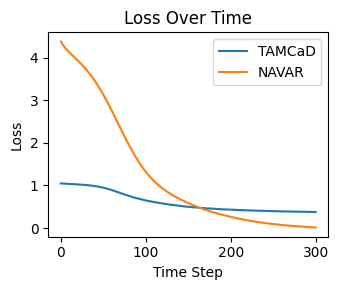

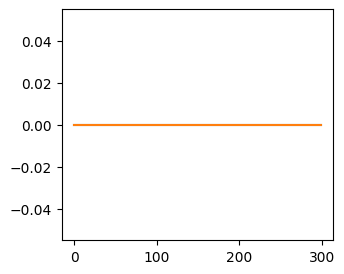

In [5]:
# Time steps for plotting
time_steps = np.arange(T)

# Plotting Loss for all models
plt.figure(figsize=(3.5,3))
for i, model_name in enumerate(model_names):
    plt.plot(time_steps, avg_losses[i], label=f'{model_name}')
    plt.fill_between(time_steps, avg_losses[i] - 2*std_losses[i], avg_losses[i] + 2*std_losses[i], alpha=0.2)

plt.title('Loss Over Time')
plt.xlabel('Time Step')
plt.ylabel('Loss')
#plt.ylim(0.1, 0.6)  # Setting the y-axis limit for loss
plt.legend()
plt.tight_layout()
plt.savefig('noise_loss_plot.png', dpi=200)
plt.show()

# Plotting AUROC for all models
plt.figure(figsize=(3.5,3))
for i, model_name in enumerate(model_names):
    plt.plot(time_steps, avg_aurocs[i], label=f'{model_name}')
    plt.fill_between(time_steps, avg_aurocs[i] - 2*std_aurocs[i], avg_aurocs[i] + 2*std_aurocs[i], alpha=0.2)

In [6]:
matrices = []
for i, (model_name, results_list) in enumerate(all_results.items()):
    matrices.append(torch.stack([results_list[i]['train_artifacts']['matrix'] for i in range(1)]).mean(dim=0))
matrices = torch.stack(matrices)
matrices.shape

torch.Size([2, 12, 12])

In [7]:
attn_logits = all_results['TAMCaD'][0]['train_artifacts']['attention_logits'].mean(dim=-1)
tau = 0.15
attn_softmax = torch.softmax(attn_logits / tau, dim=-1)
attn_softmax.shape

torch.Size([12, 12])

tensor([[11.2151,  0.8210,  1.3979,  0.5294,  1.4605,  0.5835,  1.0392,  0.4894,
          0.9563,  0.5587,  0.9625,  0.8498],
        [ 1.7245,  1.1038,  0.7537,  0.8056,  0.4566,  0.4362,  0.7097,  1.0011,
          0.4552,  0.5421,  0.4724,  0.3418],
        [ 1.0142,  0.9601,  0.8524,  0.7698,  0.6399,  0.8688,  0.9445,  0.5320,
          1.1984,  1.0680,  0.7450,  1.3622],
        [ 1.6867,  1.3056,  0.9738,  0.5832,  1.0427,  0.5889,  1.9856,  0.8947,
          0.7287,  0.8614,  0.4234,  0.4242],
        [ 2.9496,  0.5465,  1.7761,  0.8935,  1.1410,  0.8448,  0.8247,  0.4918,
          1.0588,  1.1261,  1.7103,  0.5658],
        [38.7475,  0.9642,  0.8789,  0.8351,  1.1119,  0.5206,  0.9069,  0.4434,
          1.4953,  0.7711,  0.9197,  3.8506],
        [ 2.1837,  2.2110,  1.4060,  1.0210,  1.7580,  1.5442,  1.2866,  1.4036,
          1.1233,  3.2772,  1.0772,  0.4495],
        [ 0.7775,  0.4472,  0.2719,  0.3711,  0.3730,  0.2531,  0.8199,  1.2218,
          0.4473,  0.5540,  0.

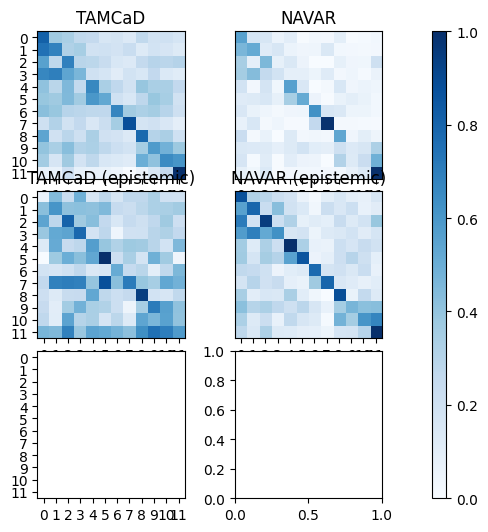

In [22]:

tamcad_matrix = all_results['TAMCaD'][0]['train_artifacts']['matrix']
navar_matrix = all_results['NAVAR'][0]['train_artifacts']['matrix']
tamcad_ep = min_max_normalization(all_results['TAMCaD'][0]['train_artifacts']['matrix_ep'])
navar_ep = min_max_normalization(all_results['NAVAR'][0]['train_artifacts']['matrix_ep'])

print(tamcad_matrix / (tamcad_ep + 0.01))
print(torch.log(tamcad_matrix / (tamcad_ep + 0.01)))
tamcad_certain = min_max_normalization(torch.log(tamcad_matrix / (tamcad_ep + 0.01)))
print(tamcad_certain)

plot_heatmaps_grid([[tamcad_matrix, navar_matrix], [tamcad_ep, navar_ep], [tamcad_certain, None]], names=[['TAMCaD', 'NAVAR'], ['TAMCaD (epistemic)', 'NAVAR (epistemic)'], ['', '']] )
fig = plt.gcf()
fig.set_size_inches(5, 5, forward=True)
plt.savefig('heatmap.png', dpi=300)
plt.show()